<a href="https://colab.research.google.com/github/liyzcj/ann/blob/master/project/fashion_mnist_noise_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed-forward nets for image classification

## Import

In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
  
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install mnist

In [0]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import torchvision.datasets as dsets

In [0]:
def show_mnist(X, title = None, loc = 'center',**kwargs):
    num = X.shape[0]
    if num <= 10:
        imgs = np.moveaxis(X.reshape(-1, num, 28, 28), 1, 2).reshape(-1, num * 28)
        plt.figure(figsize=(num/2,num))
        if title:
            plt.title(title, kwargs, loc=loc)
        plt.axis('off')
        plt.imshow(imgs)
    elif num <= 100 and num % 10 == 0:
        imgs = np.moveaxis(X.reshape(-1, 10, 28, 28), 1, 2).reshape(-1, 10 * 28)
        plt.figure(figsize=(10,20))
        if title:
            plt.title(title, kwargs, loc=loc)
        plt.axis('off')
        plt.imshow(imgs)
    elif num <= 200 and num % 20 == 0:
        imgs = np.moveaxis(X.reshape(-1, 20, 28, 28), 1, 2).reshape(-1, 20 * 28)
        plt.figure(figsize=(10,20))
        if title:
            plt.title(title, kwargs, loc=loc)
        plt.axis('off')
        plt.imshow(imgs)
    else:
        print(f'{num} not fit, choose from:')
        print(list(range(1,10)))
        print([x for x in range(10,100,10)])
        print([x for x in range(100,1000,100)])
    plt.show()

### Fashion-Mnist

In [0]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

fashion_mnist = dsets.FashionMNIST(root='./data', 
                            train=True, 
                            transform=transform,
                            download=True
                           )

train_imgs = fashion_mnist.train_data.numpy()[:50000]
train_labels = fashion_mnist.train_labels.numpy()[:50000]
test_imgs = fashion_mnist.train_data.numpy()[50000:]
test_labels = fashion_mnist.train_labels.numpy()[50000:]
labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

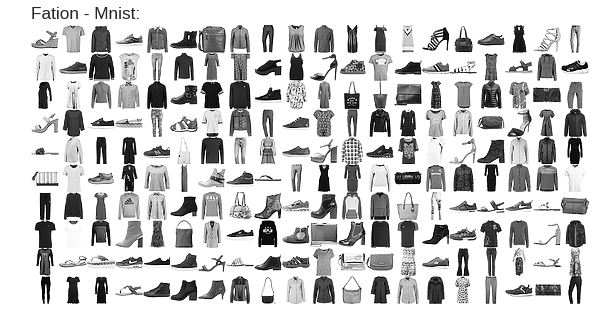

In [0]:
idxs = np.random.choice(len(fmnist), 200)
imgs = fmnist[idxs].numpy()
show_mnist(imgs,'Fation - Mnist:',loc = 'left', fontsize = 'xx-large')

### Data standardization

Rescale input values to have zero mean and standard deviation of one.

In [0]:
mean, std  = train_imgs.mean(), train_imgs.std()
train_imgs = (train_imgs - mean) / std
test_imgs = (test_imgs - mean) / std

### See some inputs

In [0]:
from typing import List
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## 2. Building feed forward-networks

### Layers

Each layer will have three methods:
 - `forward` computes and returns ${\bf y}^{(l)} = f_l\left({\bf x}^{(l)}, {\bf w}^{(l)}\right)$
 - `backward` gets $\frac{\partial {\cal L}}{\partial {\bf y}^{(l)}}$, and stores $\frac{\partial {\cal L}}{\partial {\bf w}^{(l)}}$ internally, and returns $\frac{\partial {\cal L}}{\partial {\bf w}^{(l)}}$
 - `update` modifies parameters ${\bf w}^{(l)}$ using stored $\frac{\partial{\cal L}}{\partial{\bf w}}$

In [0]:
class Layer:

    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def update(self, *args, **kwargs):
        pass  # If a layer has no parameters, then this function does nothing

### The feed-forward netowork

In [0]:
class FeedForwardNetwork:
    
    def __init__(self, layers: List[Layer]):
        self.layers = layers
        
    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self._inputs = []
        for layer in self.layers:
            if train:
                self._inputs.append(x)
            x = layer.forward(x)
        return x
    
    def backward(self, dy:np.ndarray) -> np.ndarray:
        # TODO <0> : Compute the backward phase
        """
        LI YANZHE
        """
        for layer in self.layers[::-1]:
            dy = layer.backward(self._inputs.pop(), dy)
            
        # return dy
        #raise NotImplementedError
        del self._inputs
    
    def update(self, *args, **kwargs):
        for layer in self.layers:
            layer.update(*args, **kwargs)

### The linear layer

In [0]:
class Linear(Layer):
    
    def __init__(self, insize: int, outsize: int) -> None:
        bound = np.sqrt(6. / insize)
        self.weight = np.random.uniform(-bound, bound, (insize, outsize))
        self.bias = np.zeros((outsize,))
        
        self.dweight = np.zeros_like(self.weight)
        self.dbias = np.zeros_like(self.bias)
        # for nesterov
        self.vw = np.zeros_like(self.dweight)
        self.vb = np.zeros_like(self.bias)
        # for adam
        self.mw = np.zeros_like(self.dweight)
        self.mb = np.zeros_like(self.bias)
        self.iter = 1
#         # for nestrov
#         self.v = np.zeros_like(self.dweight)
#         self.vw = np.zeros_likei(self.bias)
#         self.last_dweight = np.zeros_like(self.dweight)
#         self.last_bias = np.zeros_like(self.bias)
#         self.flag = 0
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        # TODO <1> : compute the output of a linear layer
        """
        LI YANZHE
        """
        out = np.dot(x, self.weight) + self.bias
        # self.a = output
        return out
        raise NotImplementedError
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        # TODO <2> : compute dweight, dbias and  return dx
        """
        LI YANZHE
        """
        self.dweight = np.dot(np.transpose(x), dy)
        self.dbias = np.sum(dy, axis=0)
        
        dx = np.dot(dy, np.transpose(self.weight))
        return dx
        raise NotImplementedError
    
    def update(self, mode='SGD', lr=0.001, mu=.9):
        if mode == 'SGD':
            self.weight -= lr * self.dweight
            self.bias -= lr * self.dbias
        elif mode == 'Nesterov':
            # TODO <9> : compute the nesterov update (for Lab 2)
            """
            LI YANZHE
            """
            v_pre_w = self.vw.copy()
            v_pre_b = self.vb.copy()
            
            self.vw = mu * self.vw - lr * self.dweight
            self.vb = mu * self.vb - lr * self.dbias
            
            self.weight += - mu * v_pre_w + (1 + mu) * self.vw
            self.bias += - mu * v_pre_b + (1 + mu) * self.vb
            
#             if self.flag == 0:
#                 self.last_dweight = self.dweight.copy()
#                 self.last_bias = self.bias.copy()
#                 self.vw = np.zeros_like(self.dweight)
#                 self.vb = np.zeros_like(self.bias)
#                 self.flag = 1
                
#             # update v
#             self.vw = mu * self.vw + self.dweight + mu * (self.dweight - self.last_dweight)
#             self.vb = mu * self.vb + self.dbias + mu * (self.bias - self.last_bias)
#             # save this weight and bias as last weight and bias
#             self.last_bias = self.bias.copy()
#             self.last_dweight = self.dweight.copy()
#             # update weight and bias
#             self.weight = self.weight - lr * self.vw
#             self.bias = self.bias - lr * self.vb
            
            
            # raise NotImplementedError
        elif mode == 'Adam':
            eps = np.finfo(float).eps
            # TODO <10> : compute the Adam update  (for Lab 2)
            self.mw = mu * self.mw + (1 - mu) * self.dweight
            mt = self.mw / (1 - mu ** self.iter)
            self.vw = mu * self.vw + (1 - mu) * (self.dweight ** 2)
            vt = self.vw / (1 - mu ** self.iter)
            self.weight += - lr * mt / (np.sqrt(vt) + eps)
            
            self.mb = mu * self.mb + (1 - mu) * self.dbias
            mt = self.mb / (1 - mu ** self.iter)
            self.vb = mu * self.vb + (1 - mu) * (self.dbias ** 2)
            vt = self.vb / (1 - mu ** self.iter)
            self.bias += - lr * mt / (np.sqrt(vt) + eps)
            
            self.iter += 1
            # raise NotImplementedError

### The Rectified Linear Unit
$$y = \max\left(x, 0\right)$$

In [0]:
class ReLU(Layer):
    
    def __init__(self) -> None:
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        # TODO <3> : Compute the output of a rectified linear unit
        """
        LI YANZHE
        """
        x = x * (x > 0)
        return x
        raise NotImplementedError
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        # TODO <4> : Compute the gradient w.r.t. x
        """
        LI YANZHE
        """
        dx = dy * (x > 0)
        return dx
        raise NotImplementedError

## 3. The loss function

   The negative log likelihood combines a softmax activation, and a cross-entropy cost.

In [0]:
class NegativeLogLikelihood:
    
    def __init__(self):
        pass

    def forward(self, y: np.ndarray, t: np.ndarray) -> float:
        # TODO <5> : Compute the negative log likelihood
        """
        LI YANZHE
        """
        # process t
        m = t.shape[0]
        T = np.repeat(np.arange(10).reshape(1,10), m, axis=0)
        t = t.reshape(-1,1)
        T = T == t
        # softmax 
        s = np.exp(y) / np.sum(np.exp(y), axis=1).reshape(-1,1)
        loss = - np.sum(T * np.log(s))/m
        return loss
        raise NotImplementedError
    
    def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        # TODO <6> : Compute dl/dy
        """
        LI YANZHE
        """
        m = t.shape[0]
        T = np.repeat(np.arange(10).reshape(1,10), m, axis=0)
        t = t.reshape(-1,1)
        T = T == t
        # softmax 
        s = np.exp(y) / np.sum(np.exp(y), axis=1).reshape(-1,1)
        dy = (s - T) /m
        return dy
        raise NotImplementedError

### Accuracy

In [0]:
def accuracy(y: np.ndarray, t: np.ndarray) -> float:
    # TODO <7> : Compute accuracy
    """
    LI YANZHE
    """
    # process t
    m = t.shape[0]
    # T = np.repeat(np.arange(10).reshape(1,10), m, axis=0)
    # t = t.reshape(-1,1)
    # T = T == t
    # process y
    y = np.argmax(y, axis = 1)
    # compute accuracy
    # a = np.sum(y * T) / m
    a = np.sum(y == t) / m
    return a
    raise NotImplementedError

## 4. Training a neural network

### Initial neural network

In [0]:
BATCH_SIZE = 128
HIDDEN_UNITS = 200
EPOCHS_NO = 10

optimize_args = {'mode': 'Adam', 'lr': .001}

net = FeedForwardNetwork([Linear(784, HIDDEN_UNITS),
                          ReLU(),
                          Linear(HIDDEN_UNITS, 10)])
nll = NegativeLogLikelihood()

### Train 

In [0]:
for epoch in range(EPOCHS_NO):
    for b_no, idx in enumerate(range(0, len(train_imgs), BATCH_SIZE)):
        # 1. Prepare next batch
        x = train_imgs[idx:idx + BATCH_SIZE,:,:].reshape(-1, 784)
        t = train_labels[idx:idx + BATCH_SIZE]
        
        # TODO <8> : Compute gradient
        """
        LI YANZHE
        """
        # 2. Compute gradient
        # process forward propagation
        y = net.forward(x)
        loss = nll.forward(y, t)
        # compute dy
        dy = nll.backward(y, t)
        # process backward propagation
        net.backward(dy)
        
        # raise NotImplementedError
        # 3. Update network parameters
        net.update(**optimize_args)
        
        print(f'\rEpoch {epoch + 1:02d} '
              f'| Batch {b_no:03d} '
              f'| Train NLL: {loss:3.5f} '
              f'| Train Accuracy: {accuracy(y, t):3.2f} ', end='')

    y = net.forward(test_imgs.reshape(-1, 784), train=False)
    test_nll = nll.forward(y, test_labels)
    print(f' | Test NLL: {test_nll:3.5f} '
          f' | Test Accuracy: {accuracy(y, test_labels):3.2f}')

Epoch 01 | Batch 390 | Train NLL: 0.60387 | Train Accuracy: 0.78  | Test NLL: 0.38802  | Test Accuracy: 0.86
Epoch 02 | Batch 390 | Train NLL: 0.47303 | Train Accuracy: 0.84  | Test NLL: 0.36584  | Test Accuracy: 0.87
Epoch 03 | Batch 390 | Train NLL: 0.37962 | Train Accuracy: 0.88  | Test NLL: 0.35154  | Test Accuracy: 0.87
Epoch 04 | Batch 390 | Train NLL: 0.32304 | Train Accuracy: 0.88  | Test NLL: 0.34076  | Test Accuracy: 0.88
Epoch 05 | Batch 390 | Train NLL: 0.28498 | Train Accuracy: 0.90  | Test NLL: 0.33020  | Test Accuracy: 0.88
Epoch 06 | Batch 390 | Train NLL: 0.28136 | Train Accuracy: 0.90  | Test NLL: 0.33517  | Test Accuracy: 0.88
Epoch 07 | Batch 390 | Train NLL: 0.23879 | Train Accuracy: 0.93  | Test NLL: 0.33850  | Test Accuracy: 0.88
Epoch 08 | Batch 390 | Train NLL: 0.24108 | Train Accuracy: 0.91  | Test NLL: 0.34759  | Test Accuracy: 0.88
Epoch 09 | Batch 390 | Train NLL: 0.21998 | Train Accuracy: 0.96  | Test NLL: 0.35890  | Test Accuracy: 0.88
Epoch 10 | Batch 39

## 5. Pradict Number

Pradict Labels: ['pullover', 'trouser', 'sandal', 'trouser', 'shirt', 'sandal', 'ankle_boots', 'bag', 't_shirt_top', 'bag', 'pullover', 'ankle_boots', 'shirt', 't_shirt_top', 'dress']
Correct Labels: ['pullover', 'trouser', 'sandal', 'trouser', 'shirt', 'sandal', 'ankle_boots', 'bag', 't_shirt_top', 'bag', 'pullover', 'ankle_boots', 'shirt', 't_shirt_top', 'dress']


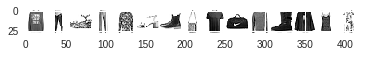

In [0]:
# random get number
idxs = np.random.randint(0, len(test_imgs), 15)
imgs = np.concatenate(tuple(test_imgs[idx,:,:] for idx in idxs), axis=1)
x = np.array([test_imgs[idx,:,:] for idx in idxs]).reshape(-1,784)
#pradicate number
y = net.forward(x)
y = np.argmax(y,axis=1)
plt.imshow(imgs)
print("Pradict Labels:",[labels[i] for i in y])
print("Correct Labels:",[labels[i] for i in test_labels[idxs]])

# Pradict with Noise

## Choose Data

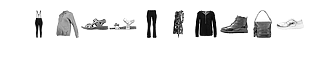

In [0]:
idxs = np.random.randint(0, len(test_imgs), 10)
data = test_imgs[idxs]
data = data.reshape(-1,784)
show_mnist(data)

## Add Noise

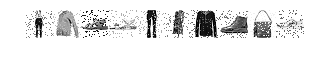

In [0]:
level = 100

for img in data:
  noisepix = np.random.choice(784, level, replace=False)
  img[noisepix] = (np.random.randint(255) - mean) / std
  
show_mnist(data)

## Predict

Predict: ['trouser', 'shirt', 'sandal', 'sandal', 'trouser', 'dress', 'pullover', 'ankle_boots', 'bag', 'sandal']
Correct: ['trouser', 'shirt', 'sandal', 'sandal', 'trouser', 'dress', 'shirt', 'ankle_boots', 'bag', 'sneaker']


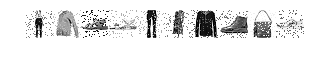

In [0]:
y = net.forward(data)
y = np.argmax(y,axis=1)
print("Predict:",[labels[i] for i in y])
print("Correct:",[labels[i] for i in test_labels[idxs]])
show_mnist(data)

## For all Test Data

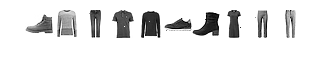

level: 0%, Accuracy : 0.8832


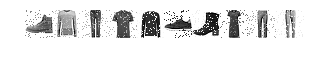

level: 10%, Accuracy : 0.8589


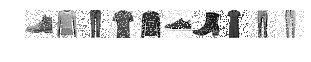

level: 20%, Accuracy : 0.8158


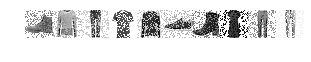

level: 30%, Accuracy : 0.7427


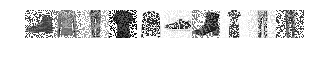

level: 40%, Accuracy : 0.6228


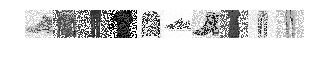

level: 50%, Accuracy : 0.4948


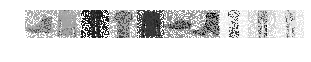

level: 60%, Accuracy : 0.3974


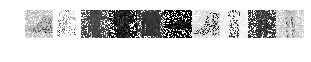

level: 70%, Accuracy : 0.3133


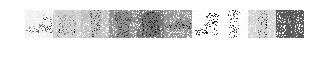

level: 80%, Accuracy : 0.2391


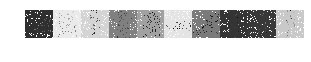

level: 90%, Accuracy : 0.1569


In [0]:
accuracies = []
for level in range(100):
  data = test_imgs.reshape(-1,784).copy()
  noise = np.max([1, 784 * level // 100])
  for img in data:
    noisepix = np.random.choice(784, noise, replace=False)
    img[noisepix] = (np.random.randint(255) - mean) / std
  y = net.forward(data)
  acc = accuracy(y, test_labels)
  accuracies.append(acc)
  if level % 10 == 0:
    show_mnist(data[:10])
    print(f'level: {level}%, Accuracy : {acc}')

Text(0,0.5,'Accuracy')

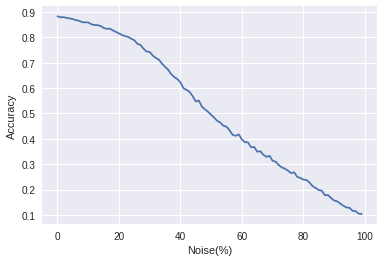

In [0]:
plt.plot(accuracies)
plt.xlabel('Noise(%)')
plt.ylabel('Accuracy')